### Pairs Trading Strategy (SBIN vs Bank of Baroda)

This notebook implements a basic mean-reversion pairs trading strategy using:
- Rolling correlation for pair validation
- OLS regression for hedge ratio estimation
- Z-score based entry and exit rules
- Transaction cost adjusted performance metrics


[*********************100%***********************]  2 of 2 completed

Average Rolling Correlation (60-day): 0.73
Hedge Ratio (OLS): 3.0497

ADF Test on Spread
ADF Statistic: -1.9165
p-value: 0.3243

===== STRATEGY PERFORMANCE =====
Final PnL (%)        : 1.72%
Number of Trades     : 56
Max Drawdown (%)     : -28.59%
Sharpe Ratio         : 0.17
Win Rate (%)         : 41.07%


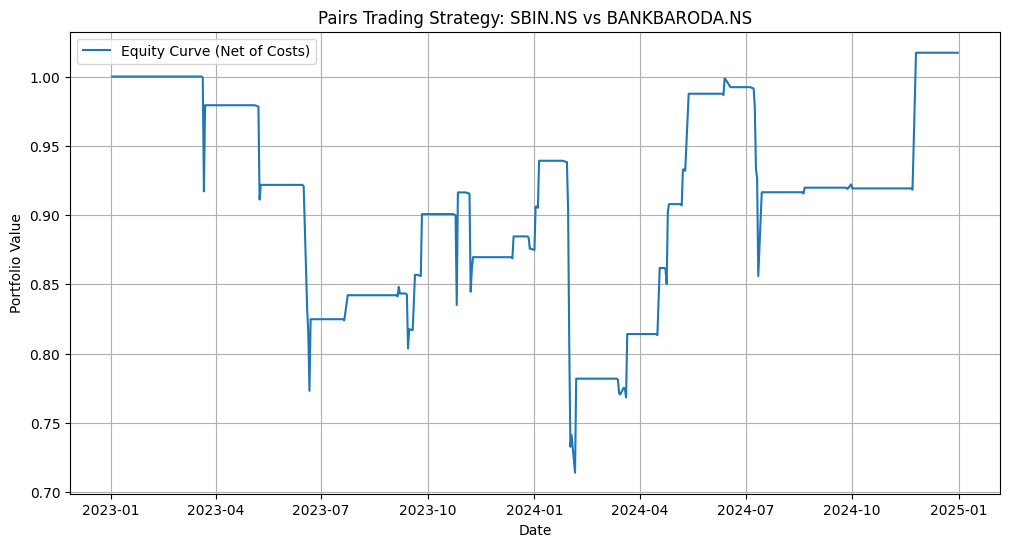

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# ==============================
# 1. CONFIGURATION
# ==============================
STOCK_Y = 'SBIN.NS'
STOCK_X = 'BANKBARODA.NS'
START_DATE = "2023-01-01"
END_DATE = "2025-01-01"
TRANSACTION_COST = 0.001  # 0.1%

# ==============================
# 2. DATA DOWNLOAD
# ==============================
data = yf.download(
    [STOCK_Y, STOCK_X],
    start=START_DATE,
    end=END_DATE,
    auto_adjust=True
)

prices = data['Close'].dropna()

# ==============================
# 3. CORRELATION CHECK
# ==============================
rolling_corr = prices[STOCK_Y].rolling(60).corr(prices[STOCK_X])
avg_corr = rolling_corr.mean()
print(f"Average Rolling Correlation (60-day): {avg_corr:.2f}")

# ==============================
# 4. HEDGE RATIO (OLS)
# ==============================
Y = prices[STOCK_Y]
X = sm.add_constant(prices[STOCK_X])

model = sm.OLS(Y, X).fit()
hedge_ratio = model.params[STOCK_X]
print(f"Hedge Ratio (OLS): {hedge_ratio:.4f}")

# ==============================
# 5. SPREAD & Z-SCORE
# ==============================
data['spread'] = prices[STOCK_Y] - hedge_ratio * prices[STOCK_X]

WINDOW = 20
data['zscore'] = (
    (data['spread'] - data['spread'].rolling(WINDOW).mean()) /
    data['spread'].rolling(WINDOW).std()
)

# ==============================
# 6. STATIONARITY CHECK (ADF)
# An Augmented Dickey-Fuller (ADF) test is applied on the spread to evaluate
# whether the price relationship shows mean-reverting behavior.

# ==============================
adf_stat, pvalue, _, _, critical_vals, _ = adfuller(data['spread'].dropna())
print("\nADF Test on Spread")
print(f"ADF Statistic: {adf_stat:.4f}")
print(f"p-value: {pvalue:.4f}")

# ==============================
# 7. TRADING SIGNALS
# ==============================
data['position'] = 0
data.loc[data['zscore'] > 2, 'position'] = -1
data.loc[data['zscore'] < -2, 'position'] = 1
data['position'] = data['position'].ffill().fillna(0)

# ==============================
# 8. RETURNS CALCULATION
# ==============================
data['strategy_return'] = (
    data['position'].shift(1) *
    (prices[STOCK_Y].pct_change()
     - hedge_ratio * prices[STOCK_X].pct_change())
)

# Transaction costs
data['trades'] = data['position'].diff().abs()
data['net_return'] = data['strategy_return'] - TRANSACTION_COST * data['trades']

# Equity curve
data['equity_curve'] = (1 + data['net_return'].fillna(0)).cumprod()

# ==============================
# 9. PERFORMANCE METRICS
# ==============================
# PnL %
final_pnl = (data['equity_curve'].iloc[-1] - 1) * 100

# Max Drawdown %
rolling_max = data['equity_curve'].cummax()
drawdown = (data['equity_curve'] / rolling_max) - 1
max_drawdown = drawdown.min() * 100

# Sharpe Ratio
sharpe = (data['net_return'].mean() / data['net_return'].std()) * np.sqrt(252)

# Number of trades
num_trades = data['trades'].sum()

# Win rate
trade_returns = data.loc[data['trades'] > 0, 'net_return']
win_rate = (trade_returns > 0).mean() * 100 if len(trade_returns) > 0 else 0

# ==============================
# 10. RESULTS
# ==============================
print("\n===== STRATEGY PERFORMANCE =====")
print(f"Final PnL (%)        : {final_pnl:.2f}%")
print(f"Number of Trades     : {int(num_trades)}")
print(f"Max Drawdown (%)     : {max_drawdown:.2f}%")
print(f"Sharpe Ratio         : {sharpe:.2f}")
print(f"Win Rate (%)         : {win_rate:.2f}%")

# ==============================
# 11. PLOT
# ==============================
plt.figure(figsize=(12, 6))
plt.plot(data['equity_curve'], label='Equity Curve (Net of Costs)')
plt.title(f'Pairs Trading Strategy: {STOCK_Y} vs {STOCK_X}')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

# ## Conclusion

# This implementation demonstrates a complete end-to-end workflow for
# pairs trading in Indian equity markets, incorporating realistic costs
# and standard evaluation metrics.

